# Свертка изображений

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from matplotlib import cm
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")
%matplotlib inline

## Загрузка изображения

Загрузим любое изображение из интернета. 

In [2]:
!wget https://raw.githubusercontent.com/hushchyn-mikhail/CourseraDL/main/cnn/screencast_1/butterfly.jpg

--2022-03-28 14:08:41--  https://raw.githubusercontent.com/hushchyn-mikhail/CourseraDL/main/cnn/screencast_1/butterfly.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73801 (72K) [image/jpeg]
Saving to: ‘butterfly.jpg’

butterfly.jpg       100%[===================>]  72.07K  --.-KB/s    in 0.02s   

2022-03-28 14:08:42 (4.57 MB/s) - ‘butterfly.jpg’ saved [73801/73801]



## Чтение изображения

Image format: JPEG; shape: (640, 427); color scheme: RGB


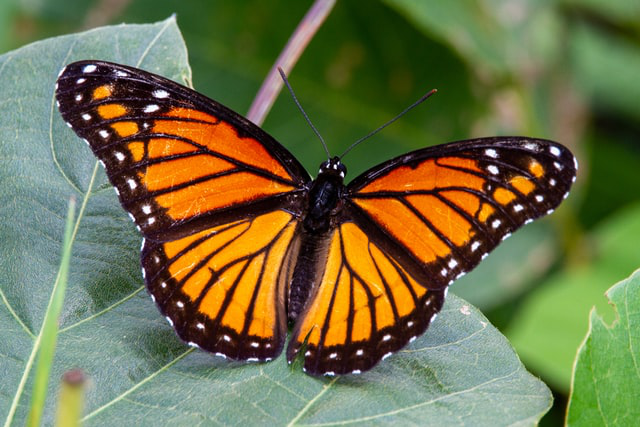

In [3]:
# !pip install Pillow
from PIL import Image

img = Image.open("butterfly.jpg")
print(f"Image format: {img.format}; shape: {img.size}; color scheme: {img.mode}")
img

## Матричное представление изображения

Мы знаем, что цветное изображение состоит из 3 числовых матриц или трехмерного тензора. Каждая матрица соответствует одному из 3 базовых цветов: красному, зеленому и синему.

Image matrix shape: (427, 640, 3)


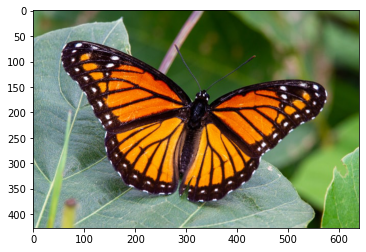

In [4]:
# получаем тензор
img_matrix = np.array(img)

# (высота, ширина, число каналов)
print(f"Image matrix shape: {img_matrix.shape}")

# нарисуем картинку матплотлибом
plt.imshow(img_matrix)
plt.show()

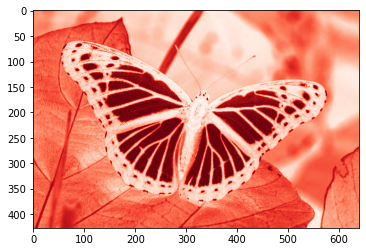

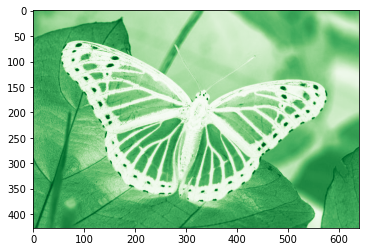

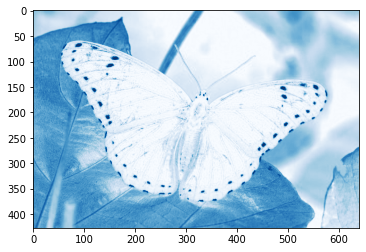

In [5]:
# посмотрим на все каналы изображения отдельно
plt.imshow(img_matrix[:, :, 0], cmap=cm.Reds)
plt.show()

plt.imshow(img_matrix[:, :, 1], cmap=cm.Greens)
plt.show()

plt.imshow(img_matrix[:, :, 2], cmap=cm.Blues)
plt.show()

# Операция свертки

В PyTorch свёрточный слой представлен в модуле `nn` функцией [`Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) с параметрами:
- количество входных каналов `in_channels`
- количество выходных каналов `out_channels`
- размер ядра `kernel_size`
- шаг `stride`
- паддинг `padding`
- режим паддинга `padding_mode` (`'zeros'`, `'reflect'` и др.)
- `dilation`

**Размер ядра** - `int`, если ядро квадратное и кортеж из двух чисел, если ядро прямоугольное. Задает размер фильтра, с которым производится свертка изображения.

![no_padding_no_strides.gif](no_padding_no_strides.gif)

Эта и следующие анимации взяты [здесь](https://github.com/vdumoulin/conv_arithmetic)

**Шаг** - задает шаг, в пикселях, на который сдвигается фильтр. `int`, если по горизонтали и вертикали сдвигается на одно и то же число. Кортеж из двух чисел, если сдвиги разные.

![no_padding_strides.gif](no_padding_strides.gif)

Шаг: 2

**Паддинг** - количество пикселей, которыми дополняется изображение. Аналогично шагу и размеру ядра, может быть, как `int`, так и кортежем из двух чисел.

**Half pading**
![same_padding_no_strides.gif](same_padding_no_strides.gif)

# Свертка изображения


Применим оператор Собеля для детектирования границ на изображении.

In [6]:
import torch
from torch.nn.functional import conv2d

Конвертируем изображение в нужный формат для PyTorch

In [7]:
img_tensor = torch.tensor([img_matrix], dtype=torch.float)
img_tensor.size()  # (число изображений, высота, ширина, число каналов)

torch.Size([1, 427, 640, 3])

In [8]:
img_tensor = img_tensor.permute(0, 3, 1, 2)
img_tensor.size()  # (число изображений, число каналов, высота, ширина)

torch.Size([1, 3, 427, 640])

Зададим оператор Собеля для детектирования горизонтальных границ

In [9]:
sobel_hor = [[-1, -2, -1], 
             [ 0,  0,  0], 
             [ 1,  2,  1]]

# одна матрица на каждый канал картинки
kernel  = [[sobel_hor, sobel_hor, sobel_hor]]
kernel = torch.tensor(kernel, dtype=torch.float)
kernel.size() # (число выходных каналов, число входных каналов, высота, ширина)

torch.Size([1, 3, 3, 3])

In [10]:
# свернём картинку с подготовленным ядром свёртки
img_conv_hor = conv2d(img_tensor, kernel)
img_conv_hor = img_conv_hor.permute(0, 2, 3, 1)
img_conv_hor.size()  # (число изображений, высота, ширина, число каналов)

torch.Size([1, 425, 638, 1])

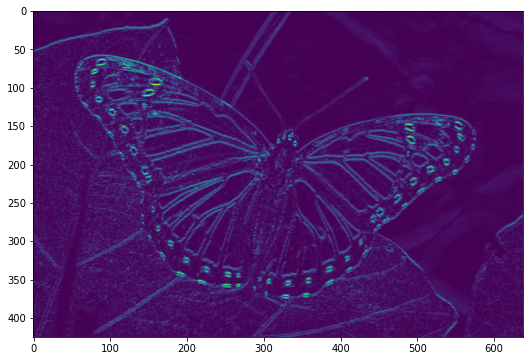

In [11]:
plt.figure(figsize=(1.5 * 7, 1.5 * 4))
plt.imshow(torch.abs(img_conv_hor[0, :, :, 0]))
plt.show()

Зададим оператор Собеля для детектирования вертикальных границ

In [12]:
sobel_ver = [[-1, 0, 1], 
             [-2, 0, 2], 
             [-1, 0, 1]]

# одна матрица на каждый канал картинки
kernel  = [[sobel_ver, sobel_ver, sobel_ver]]
kernel = torch.tensor(kernel, dtype=torch.float)
kernel.size() #(число выходных каналов, число входных каналов, высота, ширина)

torch.Size([1, 3, 3, 3])

In [13]:
img_conv_ver = conv2d(img_tensor, kernel)

img_conv_ver = img_conv_ver.permute(0, 2, 3, 1)
img_conv_ver.size() #(число изображений, высота, ширина, число каналов)

torch.Size([1, 425, 638, 1])

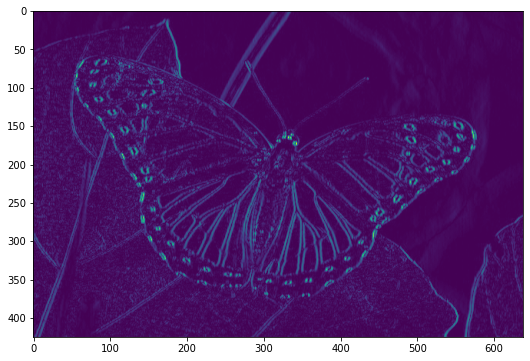

In [14]:
plt.figure(figsize=(1.5 * 7, 1.5 * 4))
plt.imshow(torch.abs(img_conv_ver[0, :, :, 0]))
plt.show()

Объединим два изображения

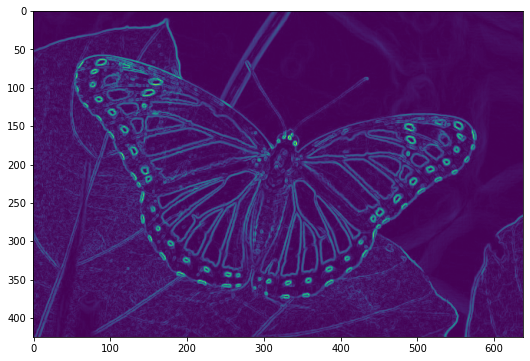

In [15]:
img_conv = torch.sqrt(img_conv_ver**2 + img_conv_hor**2)

plt.figure(figsize=(1.5 * 7, 1.5 * 4))
plt.imshow(img_conv[0, :, :, 0])
plt.show()

### Задание 1
По аналогии с примером выше, сверните изображение со случайным ядром такого же размера.

**Подсказка:** используйте `torch.rand()`.

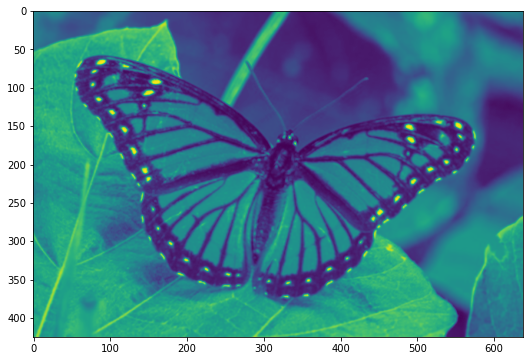

In [16]:
### solution
kernel = torch.rand((1, 3, 3, 3), dtype=torch.float)
### the end

# свертка изображения
img_conv_ver = conv2d(img_tensor, kernel)
img_conv_ver = img_conv_ver.permute(0, 2, 3, 1)

# рисуем результат
plt.figure(figsize=(1.5 * 7, 1.5 * 4))
plt.imshow(torch.abs(img_conv_ver[0, :, :, 0]))
plt.show()

# Полносвязная нейронная сеть

Решим задачу классификации изображений полносвзяной нейронной сетью из прошлого семинара.

In [17]:
import torch
import torch.nn.functional as F
import torchvision
from torch import nn

Скачаем и подготовим уже знакомые нам данные для классификации.

In [18]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ]
)

mnist_train = torchvision.datasets.MNIST(
    "./mnist/", 
    train=True, 
    download=True, 
    transform=transform
) 
mnist_val = torchvision.datasets.MNIST(
    "./mnist/",
    train=False, 
    download=True,
    transform=transform
)


train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=64, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



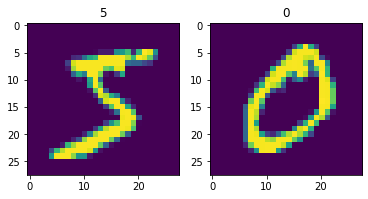

In [19]:
# ещё раз посмотрим на то, с чем мы работаем
for i in [0, 1]:
    plt.subplot(1, 2, i + 1)
    plt.imshow(mnist_train[i][0].squeeze(0).numpy().reshape([28, 28]))
    plt.title(str(mnist_train[i][1]))
plt.show()

Обучаем полносвязную нейронную сеть для классификации изображений так же, как мы это делали на прошлом семинаре

In [20]:
model = nn.Sequential(
    nn.Flatten(),             # превращаем картинку 28х28 в вектор размером 784
    nn.Linear(28 * 28, 128),  # линейный слой, преобразующий вектор размера 784 в вектор размера 128
    nn.ReLU(),                # нелинейность
    nn.Linear(128, 10),       # линейный слой, преобразующий вектор размера 128 в вектор размера 10
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01) # создаем оптимизатор и передаем туда параметры модели

In [21]:
def train(model, optimizer, n_epochs=5):
    for epoch in range(n_epochs):
        # тренировка
        for x_train, y_train in tqdm(train_dataloader):           
            y_pred = model(x_train)
            loss = F.cross_entropy(y_pred, y_train)
            
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()
        
        
        # валидация
        if epoch % 2 == 0:
            val_loss = []
            val_accuracy = []
            with torch.no_grad():
                for x_val, y_val in tqdm(val_dataloader):
                    y_pred = model(x_val)
                    loss = F.cross_entropy(y_pred, y_val)
                    val_loss.append(loss.numpy())
                    val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())

            # печатаем метрики
            print(f"Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}")

In [22]:
train(model, optimizer)

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 0, loss: 0.3220333456993103, accuracy: 0.9084


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 2, loss: 0.2297585904598236, accuracy: 0.933


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 4, loss: 0.1823708713054657, accuracy: 0.9467


# Сверточный слой

Добавим в нашу сеть сверточный слой. Обратите внимание на то, как изменится качество классификации.

In [23]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5), # добавим сверточный слой с 10 ядрами
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),  # уменьшим картинку в 4 раза по каждой стороне
    nn.Flatten(),                 # превращаем картинку 6х6х10 в вектор размером 360
    nn.Linear(6*6*10, 128),       # линейный слой, преобразующий вектор размера 360 в вектор размера 128
    nn.ReLU(),                    # нелинейность
    nn.Linear(128, 10),           # отображение в пространство рамерности числа меток классификации
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [24]:
train(model, optimizer)

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 0, loss: 0.23975764214992523, accuracy: 0.9282


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 2, loss: 0.10445960611104965, accuracy: 0.9696


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 4, loss: 0.08687999099493027, accuracy: 0.9733


### Задание 2

По аналогии с предыдущим примером, обучите нейронную сеть, у которой следущие слои:

- Сверточный слой с 10 ядрами размером 5
- Функция активации ReLU
- Уменьшить картинку в 2 раза (по каждому измерению)
- Сверточный слой с 20 ядрами размером 5
- Функция активации ReLU
- Уменьшить картинку в 2 раза (по каждому измерению)
- Полносвязный слой со 128 нейронами
- Функция активации ReLU
- Выходной слой

In [25]:
### solution
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),   # добавим сверточный слой с 10 ядрами
    nn.ReLU(),                                                  # нелинейность
    nn.MaxPool2d(kernel_size=2),                                # уменьшим картинку в 2 раза
    nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5),  # добавим сверточный слой с 20 ядрами
    nn.ReLU(),                   # нелинейность
    nn.MaxPool2d(kernel_size=2), # уменьшим картинку в 2 раза
    nn.Flatten(),                # превращаем картинку 4х4х20 в вектор размером 320
    nn.Linear(4*4*20, 128),      # линейный слой, преобразующий вектор размера 320 в вектор размера 128
    nn.ReLU(),                   # нелинейность
    nn.Linear(128, 10),          # отображение в пространство рамерности числа меток классификации
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [26]:
train(model, optimizer)

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 0, loss: 0.18847320973873138, accuracy: 0.9431


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 2, loss: 0.08294456452131271, accuracy: 0.9759


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 4, loss: 0.06301793456077576, accuracy: 0.9809
